In [1]:
import jax
from jax import numpy as jnp
from carlson import rfv, rjpv, rcpv, rdv, rf, rj_posp, rc_posy, rd, rf
from scipy.integrate import quad

In [187]:
# [1, 1, 1, -2]

def int23(r, z, y, x, a4, b4):

    a3 = (1 - (r**2 + z**2)) / (2 * r * z)
    
    d12 = -2
    d13 = -1 - a3
    d14 = b4 - a4
    d24 = b4 + a4
    d34 = a3 * b4 + a4

    r24 = -d24 / b4
    r14 = d14 / b4
    r34 = - d34 / b4

    x1 = jnp.sqrt(1 + x)
    x2 = jnp.sqrt(1 - x)
    x3 = jnp.sqrt(a3 - x)
    x4 = jnp.sqrt(a4 + b4 * x)

    y1 = jnp.sqrt(1 + y)
    y2 = jnp.sqrt(1 -  y)
    y3 = jnp.sqrt(a3 - y)
    y4 = jnp.sqrt(a4 + b4 * y)

    U1 = (x1 * y2 * y3 + y1 * x2 * x3) / (x - y)
    U2 = (x2 * y1 * y3 + y2 * x1 * x3) / (x - y)
    U3 = (x3 * y1 * y2 + y3 * x1 * x2) / (x - y)

    W2 = U1 * U1 - b4 * d12 * d13 / d14
    Q2 = (x4 * y4 / (x1 * y1))**2 * W2
    P2 = Q2 + b4 * d24 * d34 / d14

    I1c = 2 * rf(U3 * U3, U2 * U2, U1 * U1)
    I2c = (2 / 3) * d12 * d13 * rd(U3 * U3, U2 * U2, U1 * U1) + 2 * x1 * y1 / U1
    I3c = -2 * d12 * d13 / (3 * d14) * rj_posp(U3 * U3, U2 * U2, U1 * U1, W2) + 2 * rc_posy(P2, Q2)

    A111 = x1 * x2 * x3 - y1 * y2 * y3
    J1c = d12 * d13 * I1c - 2 * A111

    return (
        - 3 * r24 * d34 * I3c 
        + (r14 + r24 + r34) * I2c 
        - J1c
    ) / (3 * b4)

def g2_circ(r, z, y, x):

    fac = r * (1 + r + z) * (r + z - 1) * jnp.sqrt(r * z / 2) / (3 * (r + z))
    return fac * int23(r, z, y, x, 1, -1)

def g3_circ(r, z, y, x):

    a4 = (r * r + z * z) / (2 * r * z)
    fac = 2 * r * r * z * z / jnp.sqrt(2 * r * z) / (3 * (r + z) * (r - z))
    return fac * int23(r, z, y, x, a4, 1)

def ig2_num(t, r, z):

    num = -r * jnp.sqrt(1 - t * t) * (r + z - 1) * (r + z + 1) * jnp.sqrt(1 - r * r - 2 * r * t * z - z * z)
    den = 6 * (t - 1) * (r + z)
    return num / den

def ig3_num(t, r, z):

    num = 2 * r * r * z * z * jnp.sqrt(1 - t * t) * jnp.sqrt(1 - r * r - 2 * r * t * z - z * z)
    den = 3 * (r - z) * (r + z) * (r * r + 2 * r * t * z + z * z)
    return num / den

In [188]:
g2_circ(0.3, 0.1, -0.2, 0.5) - quad(ig2_num, -0.2, 0.5, args=(0.3, 0.1))[0]

Array(-2.77555756e-17, dtype=float64)

In [189]:
g3_circ(0.1, 0.4, -0.2, 0.5) - quad(ig3_num, -0.2, 0.5, args=(0.1, 0.4))[0]

Array(1.04083409e-17, dtype=float64)

In [200]:
# [1, 1, -1]

def int1(r, z, y, x):

    a2 = (1 - (r**2 + z**2)) / (2 * r * z)
    
    d12 = a2 - 1
    d13 = 2
    d23 = a2 + 1

    x1 = jnp.sqrt(1 - x)
    x2 = jnp.sqrt(a2 - x)
    x3 = jnp.sqrt(1 + x)

    y1 = jnp.sqrt(1 - y)
    y2 = jnp.sqrt(a2 - y)
    y3 = jnp.sqrt(1 + y)

    U1 = (x1 * y2 * y3 + y1 * x2 * x3) / (x - y)
    U2 = (x2 * y1 * y3 + y2 * x1 * x3) / (x - y)
    U3 = (x3 * y1 * y2 + y3 * x1 * x2) / (x - y)

    I1c = 2 * rf(U3 * U3, U2 * U2, U1 * U1)
    I2c = (2 / 3) * d12 * d13 * rd(U3 * U3, U2 * U2, U1 * U1) + 2 * x1 * y1 / U1

    A111 = x1 * x2 * x3 - y1 * y2 * y3
    J1c = d12 * d13 * I1c + 2 * A111

    return ((d23 + d13) * I2c + J1c) / 3

def g1_circ(r, z, y, x):

    fac = r * (r - z + 1) * (r - z - 1) / (6 * (r - z)) * jnp.sqrt(2 * r * z)
    return fac * int1(r, z, y, x)

def ig1_num(t, r, z):

    num = r * jnp.sqrt(1 - t) * (r - z + 1) * (r - z - 1) * jnp.sqrt(1 - r * r - 2 * r * t * z - z * z)
    den = 6 * jnp.sqrt(1 + t) * (r - z)
    return num / den

def ig1_num_nofac(t, r, z):

    return jnp.sqrt(1 - t) * jnp.sqrt(-t + (1 - (r**2 + z**2)) / (2 * r * z)) / jnp.sqrt(1 + t)
    

In [201]:
g1_circ(0.3, 0.1, -0.2, 0.5) - quad(ig1_num, -0.2, 0.5, args=(0.3, 0.1))[0]

Array(2.77555756e-17, dtype=float64)

In [242]:
def g0_circ(r, z, y, x):

    fac = r / (6 * (r + z) * (r - z))
    fx = jnp.arctan((x + z / r) / jnp.sqrt(1 - x * x))
    fy = jnp.arctan((y + z / r) / jnp.sqrt(1 - y * y))
    return (fx - fy) / 3

In [243]:
g0_circ(0.3, 0.1, -0.2, 0.5)

Array(0.21030356, dtype=float64, weak_type=True)

In [244]:
def ig0_num(t, r, z):

    num = r * (r + t * z)
    den = 3 * jnp.sqrt(1 - t * t) * (r**2 + z**2 + 2 * r * t * z)
    return num / den

In [245]:
quad(ig0_num, -0.2, 0.5, args=(0.3, 0.1))

(0.21030356381637613, 2.3348385870966674e-15)

In [284]:
def gfull_num(t, r, z):

    num = r * (r + t * z) * (1 - (1 - r**2 - z**2 - 2 * r * t * z)**1.5)
    den = 3 * jnp.sqrt(1 - t * t) * (r**2 + 2 * t * r * z + z**2)
    return num / den

quad(gfull_num, -0.2, 0.5, args=(0.3, 0.1))

(0.033365399988630626, 3.704303529320566e-16)

In [279]:
args = 0.3, 0.1, -0.2, 0.5
g0_circ(*args) + g1_circ(*args) + g2_circ(*args) + g3_circ(*args)

Array(0.0333654, dtype=float64)

In [280]:
g3_circ(*args)

Array(0.04472227, dtype=float64)

In [281]:
gfull_parts_num = lambda t, r, z: ig0_num(t, r, z) + ig1_num(t, r, z) + ig2_num(t, r, z) + ig3_num(t, r, z)

In [282]:
quad(gfull_parts_num, -0.2, 0.5, args=(0.3, 0.1))

(0.03336539998863062, 3.704303529320565e-16)

In [308]:
jnp.mod(3 * jnp.pi / 2, jnp.pi) - jnp.pi

Array(-1.57079633, dtype=float64, weak_type=True)

In [287]:
3 * jnp.pi / 4

2.356194490192345

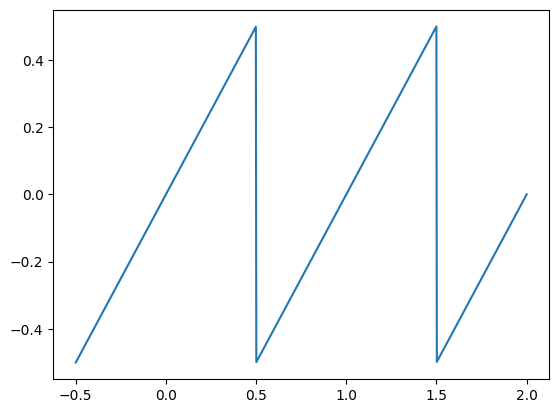

In [315]:
import matplotlib.pyplot as plt
phi = jnp.linspace(-jnp.pi/2, 2 * jnp.pi, 1000)
plt.plot(phi / jnp.pi, (jnp.mod(phi + jnp.pi / 2, jnp.pi) - jnp.pi / 2) / jnp.pi)

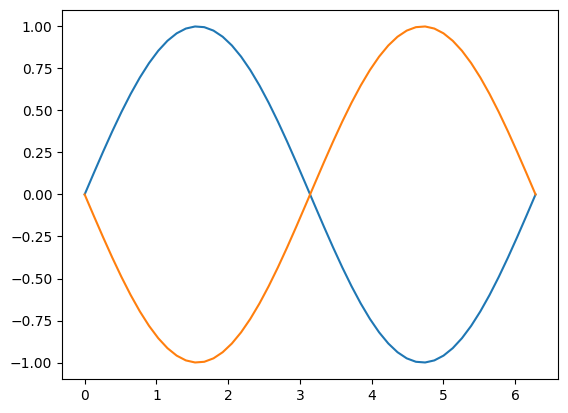

In [319]:
x = jnp.linspace(0, 2 * jnp.pi)
plt.plot(x, jnp.sin(x))
plt.plot(x, jnp.sin(2 * jnp.pi - x))

In [327]:
import numpy as np
a, b = np.random.rand(2) * 2 * np.pi
ca, cb = np.cos(a), np.cos(b)
sa, sb = np.sin(a), np.sin(b)

In [ ]:
if (ca > 0) & (cb > 0):

    if (sb > sa):
        print("(sa, sb)")
    else:
        print("complete, -(sb, sa)")

if (ca > 0) & (cb < 0):

    print("(sa, 1), -(sb, 1)")

if (ca < 0) & (cb < 0):

    print("-(sb, sa)")

if (cb > 0) & (ca < 0):